In [ ]:
# Read the CSV file
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
root_folder ="C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/"
folder_address=root_folder+"Program/Week8/Data folder/"
# freqData=pd.read_csv(folder_address+"Frequency_Envelop.csv")
freqData=pd.read_csv(folder_address+"Time_Envelop.csv")
earthquakeData=pd.read_csv(folder_address+"EqID.csv")
SiteData=pd.read_csv(folder_address+"SiteID.csv")
RSNData=pd.read_csv(folder_address+"RSN.csv")


In [ ]:
#dropping rows which  any column contains value between -34.5388 and -34.5386
for i in freqData.index:
    # if((freqData.loc[i] > 65500) & (freqData.loc[i] < 65600)).any():   #for Frequency_Envelop
    if((freqData.loc[i] > -34.5388) & (freqData.loc[i] < -34.5386)).any():  # for Time_env
        freqData = freqData.drop(i)
        earthquakeData = earthquakeData.drop(i)
        SiteData = SiteData.drop(i)
        RSNData = RSNData.drop(i)

In [ ]:
# for i in freqData.columns:
#     # plt.hist(freqData[i], bins=100)
#     # plt.xlabel(i)
#     # plt.ylabel('Frequency')
#     # plt.title(i)
#     # plt.show()
#     plt.plot(freqData[i])
#     plt.xlabel('Time')
#     plt.ylabel('Frequency')
#     plt.title(i)
#     plt.show()



In [ ]:
#for interstate data
freqData=pd.concat([earthquakeData,freqData],axis=1)
freqData=pd.concat([SiteData,freqData],axis=1)
freqData=pd.concat([RSNData,freqData],axis=1)

In [ ]:
freqData

In [ ]:
#replacing the -999 value with NaN
freqData=freqData.replace(-999,np.nan)
#droping the rows containing NaN values
freqData=freqData.dropna()

In [ ]:
#printing the corelation matrix
# freqData.corr()

In [ ]:
# Plot the scatter plot with colors
all_columns = list(freqData.columns)
X_val = all_columns[:9]
# Y_val = all_columns[6:157]
Y_val = all_columns[9:]

Xreq= freqData[X_val]
Yreq = freqData[Y_val] # Yreq is the response variable


# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    Xreq, Yreq, test_size=0.2, random_state=42)

# Extract the first column of X_test for  interstate distribution
RSN= X_test.iloc[:, 0]
Site_ID = X_test.iloc[:, 1]
Earthquake_ID = X_test.iloc[:, 2]

# Drop the first column from X_test and X_train
X_test = X_test.iloc[:, 3:]
X_train = X_train.iloc[:, 3:]

# concatenating the data
Xreq=pd.concat([X_train,X_test],axis=0)
Yreq=pd.concat([y_train,y_test],axis=0)

# Normalizing the data
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()
X_normalized = scalerX.fit_transform(Xreq)
Y_normalized = scalerY.fit_transform(Yreq)


# Getting the split data as before
X_train = X_normalized[:len(X_train)]
X_test = X_normalized[len(X_train):]
y_train = Y_normalized[:len(y_train)]
y_test = Y_normalized[len(y_train):]

len(X_train), len(X_test), len(y_train), len(y_test)


num_epochs = 1000

In [ ]:
print(X_train.shape), print(y_train.shape) 
print(X_test.shape), print(y_test.shape)

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BayesianNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BayesianNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ProbabilisticBNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(ProbabilisticBNN, self).__init__()
        self.network = BayesianNetwork(input_dim, hidden_dim, output_dim)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        output = self.network(x)
        return output

    def mc_dropout_forward(self, x, n_samples=20):
        predictions = []
        for _ in range(n_samples):
            with torch.no_grad():
                output = F.dropout(self.network(x), p=self.dropout_rate, training=True)
            predictions.append(output.unsqueeze(0))
        predictions = torch.cat(predictions, dim=0)
        mean_prediction = predictions.mean(dim=0)
        std_prediction = predictions.std(dim=0)
        return mean_prediction, std_prediction

    def kl_divergence(self):
        kl_div = 0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl_div += module.kl_loss()
        return kl_div

def train(model, train_loader, optimizer, criterion, epochs=100):
    model.train()
    mse_values = []
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        total_mse = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets) + model.kl_divergence()  # Add KL divergence to the loss
            mse = criterion(outputs, targets).item()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_mse += mse
        avg_loss = total_loss / len(train_loader)
        avg_mse = total_mse / len(train_loader)
        loss_values.append(avg_loss)
        mse_values.append(avg_mse)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}, MSE: {avg_mse}')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_values, label='Total Loss')
    plt.plot(range(1, epochs + 1), mse_values, label='MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Variation of Loss and MSE with Epoch')
    plt.legend()
    plt.grid(True)
    # plt.savefig(f'C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/Program/Week8/PBNN/Figures/loss_mse_epoch1000.png')
    plt.show()

def test(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return predictions, actuals

# Example usage:
# Assuming you have input data X_train, y_train, X_test, and y_test

# Convert your data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


# Define model, optimizer, and loss function
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]  # Assuming regression task with single output
hidden_dim = 25
learning_rate = 0.001
dropout_rate = 0.2  # Dropout rate for MC Dropout
model = ProbabilisticBNN(input_dim, hidden_dim, output_dim, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# Train the model
train(model, train_loader, optimizer, criterion, epochs=num_epochs)


In [ ]:
# torch.save(model.state_dict(), root_folder+f'Program/Week8/PBNN/model_for_TimeEnv_{num_epochs}epoch.pth')


In [ ]:
# # Check if the file exists
# import os


# file_path = root_folder+f'Program/Week8/BNNresult/model_for_freqEnv_{num_epochs}epoch.pth'
# if os.path.isfile(file_path):
#     model = torch.load(file_path)
# else:
#     print(f"File {file_path} does not exist. Please check the file path.")
# model=torch.load(file_path)

In [ ]:
#creating datalaoder for test data
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32)
# # Test the model
predictions, actuals = test(model, test_loader)

In [ ]:
#converting the normalized data back to original data
predictions = scalerY.inverse_transform(predictions)
actuals = scalerY.inverse_transform(actuals)


In [ ]:
plt.figure(figsize=(20, 10))

# Loop over all subarrays
for i in range(actuals.shape[1]):
    plt.scatter(actuals[:,i], predictions[:,i], alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
# plt.xlim(65500, 65600)
plt.grid(True)
# plt.savefig(f'${root_folder}Program/Week8/PBNN/Figures/scatter_plot_{num_epochs}epoch.png')
plt.show()

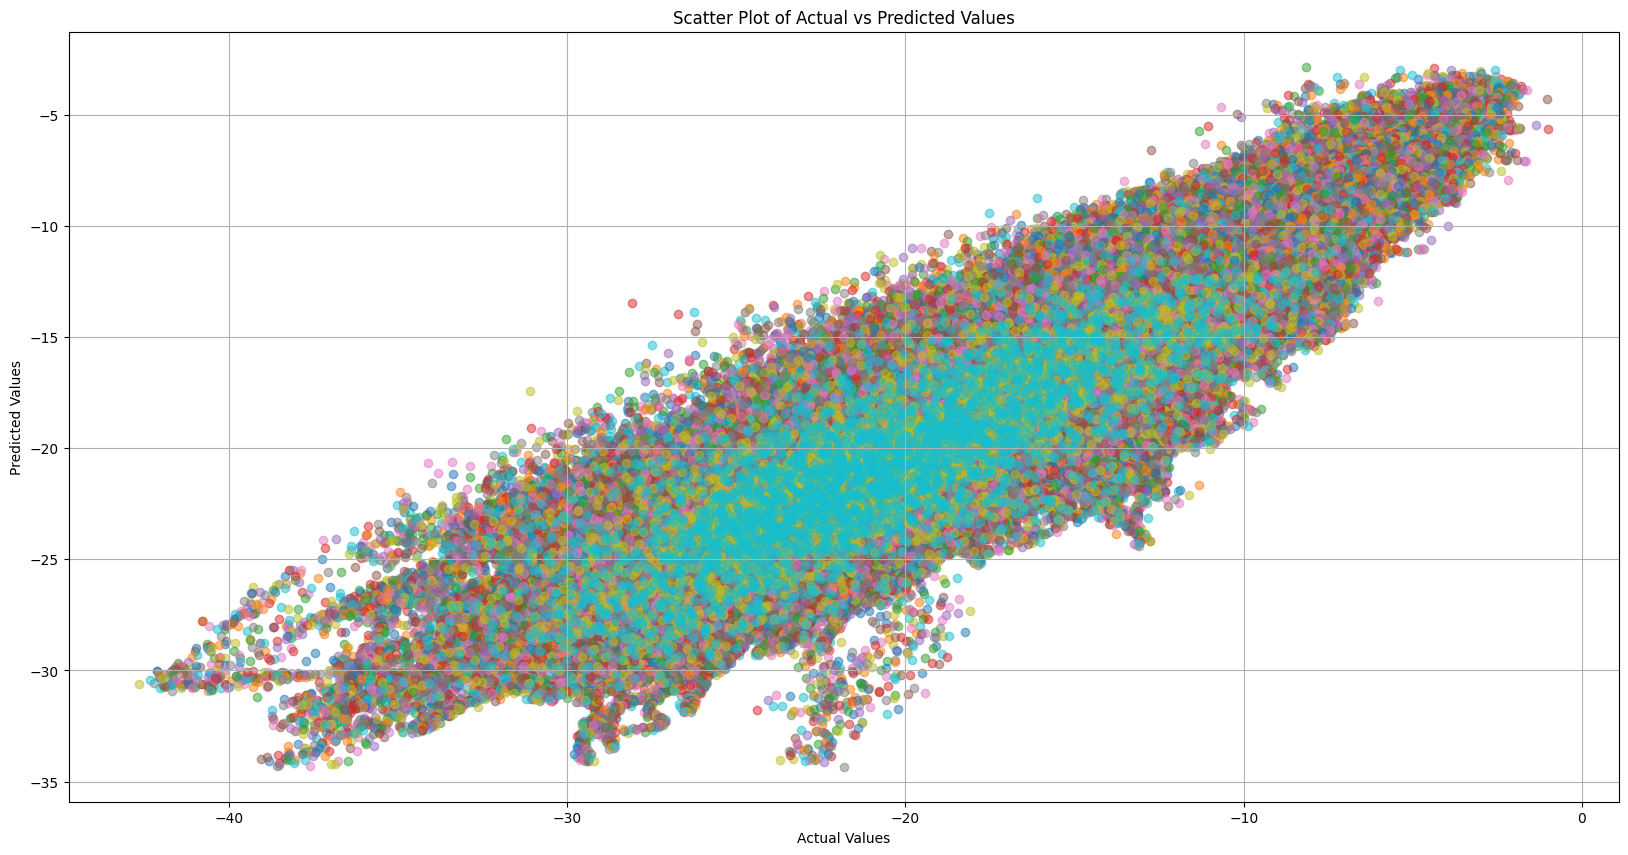


In [ ]:

from sklearn.metrics import mean_squared_error, r2_score


# Calculate MSE and R2 score
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Calculation of confidence intervals
mean_predictions, std_predictions = model.mc_dropout_forward(X_test)
confidence_intervals = (mean_predictions - 2 * std_predictions, mean_predictions + 2 * std_predictions)


Mean Squared Error: 4.740969181060791
R2 Score: 0.8213859476381149


In [ ]:
# Plotting the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(actuals[:, 0], mean_predictions[:, 0], label='Prediction', color='blue')
plt.fill_between(actuals[:, 1], confidence_intervals[0][:, 1], confidence_intervals[1][:, 1], alpha=0.3, label='Confidence Interval', color='orange')
plt.xlabel('Actual Values')
plt.ylabel('Prediction')
plt.title('Prediction with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#converting the actuals and predictions to dataframe    
actualsdf=pd.DataFrame(actuals,columns=Y_val)
predictionsdf=pd.DataFrame(predictions,columns=Y_val)


In [ ]:

# Convert the tensors to numpy arrays
y_test = y_test.numpy()
mean_predictions = mean_predictions.numpy()
lower_confidence_intervals = confidence_intervals[0].numpy()
upper_confidence_intervals = confidence_intervals[1].numpy()
std_predictions = std_predictions.numpy()

In [ ]:
#using the normalized means and stds to make a dataframe for epistemic and aleatoric uncertainty calculation
mean_predictions_df = pd.DataFrame(mean_predictions, columns=Y_val)
std_predictions_df = pd.DataFrame(std_predictions, columns=Y_val)

In [ ]:
#converting to actual values
y_test = scalerY.inverse_transform(y_test)
mean_predictions = scalerY.inverse_transform(mean_predictions)
lower_confidence_intervals = scalerY.inverse_transform(lower_confidence_intervals)
upper_confidence_intervals = scalerY.inverse_transform(upper_confidence_intervals)


Ytestdf= pd.DataFrame(y_test, columns=Y_val)
Ypreddf= pd.DataFrame(mean_predictions, columns=Y_val)
Ylowerdf= pd.DataFrame(lower_confidence_intervals, columns=Y_val)
Yupperdf= pd.DataFrame(upper_confidence_intervals, columns=Y_val)

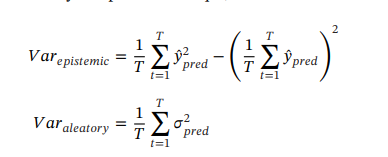

In [ ]:
var_aleatory = std_predictions_df.pow(2).mean()
var_epistemic = mean_predictions_df.var()
UncertainityStats = pd.DataFrame({'Aleatory Uncertainty': var_aleatory, 'Epistemic Uncertainty': var_epistemic})
# UncertainityStats.to_csv(f"{root_folder}Program/Week8/PBNN/UncertainityStat/UncertainityStats_epochs{num_epochs}.csv", index=False)
UncertainityStats

In [ ]:
# Adjust the time array to match the length of the 'Aleatory Uncertainty' series
time = np.arange(0, len(UncertainityStats['Aleatory Uncertainty']), 1)

plt.figure(figsize=(10, 5))
plt.plot(time, UncertainityStats['Aleatory Uncertainty'], label='Aleatory Uncertainty', color='red')
plt.xlabel('Time')
plt.ylabel('Aleatory Uncertainty')
plt.title('Variation of Aleatory Uncertainty with Time')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig(f"{root_folder}Program/Week8/PBNN/Figures/AleatoryUncertainty_epoch{num_epochs}.png")


plt.figure(figsize=(10,5))
plt.plot(time, UncertainityStats['Epistemic Uncertainty'], label='Epistemic Uncertainty', color='blue')
plt.xlabel('Time')
plt.ylabel('Epistemic Uncertainty')
plt.title('Variation of Epistemic Uncertainty with Time')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig(f"{root_folder}Program/Week8/PBNN/Figures/EpistemicUncertainty_epoch{num_epochs}.png")

In [ ]:
#plotting the reSite_IDual plot
Residuals = actuals - predictions
plt.figure(figsize=(8, 6))
plt.scatter(predictions, Residuals, alpha=0.5)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
# plt.savefig(f"{root_folder}Program/Week8/PBNN/Figures/reSite_IDual_epoch{num_epochs}.png")
plt.grid(True)
plt.show()


In [ ]:
X_test=scalerX.inverse_transform(X_test)
#Adding the Catagory_ID col to the to X_test
X_test=np.insert(X_test,0,Site_ID,axis=1)
X_test=np.insert(X_test,0,Earthquake_ID,axis=1)
X_test=np.insert(X_test,0,RSN,axis=1)
Residualsdf=pd.DataFrame(Residuals,columns=Y_val)
x_testdf=pd.DataFrame(X_test,columns=X_val)
TotalResidualsDf= pd.concat([x_testdf,Residualsdf],join='inner',axis="columns")
TotalResidualsDf


In [ ]:
#concatenating the actuals and predictions to the X_test
actualsdf=pd.concat([x_testdf,actualsdf],join='inner',axis="columns")
predictionsdf=pd.concat([x_testdf,predictionsdf],join='inner',axis="columns")

# saving the actuals and predictions to the csv file
# actualsdf.to_csv(f"{root_folder}Program/Week8/PBNN/TestData/Actuals_epoch{num_epochs}.csv", index=False)
# predictionsdf.to_csv(f"{root_folder}Program/Week8/PBNN/TestData/Predictions_epoch{num_epochs}.csv", index=False)

In [ ]:
#taking 10 equal intervals between the minimum and maximum value of the x_test and finding the mean and standard deviation of the reSite_IDuals in each interval and plotting it
colno=4
x_test = x_testdf[X_val[colno]]
num_intervals = 10
interval_size = (x_test.max() - x_test.min()) / num_intervals
interval_means = []
interval_stds = []
for i in range(num_intervals):
    lower_bound = x_test.min() + i * interval_size
    upper_bound = lower_bound + interval_size
    mask = (TotalResidualsDf[X_val[colno]] >= lower_bound) & (TotalResidualsDf[X_val[colno]] <= upper_bound)
    interval_means.append(list(TotalResidualsDf.loc[mask].mean()))
    interval_stds.append(list(TotalResidualsDf.loc[mask].std()))


In [ ]:
interval_meansdf=pd.DataFrame(interval_means,columns=X_val+Y_val)
interval_stdsdf=pd.DataFrame(interval_stds,columns=X_val+Y_val)
interval_meansdf

In [ ]:
# plotting reSite_IDual vs Rjb
for i in range(len(Y_val)):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_testdf[X_val[colno]], TotalResidualsDf[Y_val[i]], alpha=0.5, color='blue', label='ReSite_IDuals')
    plt.errorbar(np.arange(num_intervals) * interval_size + x_test.min(), interval_meansdf[f"{Y_val[i]}"], yerr=interval_stdsdf[f"{Y_val[i]}"], fmt='o', capsize=5, label='Mean Residual',color='red')
    plt.xlabel('Rjb Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot for {Y_val[i]}')
    plt.grid(True)
    plt.legend()
    # plt.savefig(f"{root_folder}Program/Week8/PBNN/Figures/Residuals_{Y_val[i]}_epoch{num_epochs}.png")
    plt.show()

In [ ]:
#getting all the unique values of the Earthquake_ID
interval_means_interevents = []
interval_stds_interevents = []
unique_values =Earthquake_ID.unique()
for i in range( unique_values.size):
    mask = (Earthquake_ID == unique_values[i]).reset_index(drop=True)
    interval_means_interevents.append(list(TotalResidualsDf.loc[mask].mean()))
    interval_stds_interevents.append(list(TotalResidualsDf.loc[mask].std()))
interval_means_intereventsdf=pd.DataFrame(interval_means_interevents,columns=X_val+Y_val)
interval_stds_intereventsdf=pd.DataFrame(interval_stds_interevents,columns=X_val+Y_val)   
interval_means_intereventsdf


In [ ]:
#getting all the unique values of the Site_ID
interval_means_intraevents = []
interval_stds_intraevents = []
unique_values =Site_ID.unique()
for i in range( unique_values.size):
    mask = (Site_ID == unique_values[i]).reset_index(drop=True)
    interval_means_intraevents.append(list(TotalResidualsDf.loc[mask].mean()))
    interval_stds_intraevents.append(list(TotalResidualsDf.loc[mask].std()))
interval_means_intraeventsdf=pd.DataFrame(interval_means_intraevents,columns=X_val+Y_val)
interval_stds_intraeventsdf=pd.DataFrame(interval_stds_intraevents,columns=X_val+Y_val)  
# interval_means_intraeventsdf["FreI_  7"]

In [ ]:
# the error bar plot for the Residuals for each magnitude
for i in range(len(Y_val)):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25, 8))
    ax1.errorbar(interval_means_intereventsdf["Mag"], interval_means_intereventsdf[Y_val[i]], fmt='o', capsize=5, label='Mean Residual',color='red')
    ax1.set_xlabel('Magnitude Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'Residual Plot for {Y_val[i]}')
    ax1.grid(True)
    ax2.errorbar(interval_means_intraeventsdf["Rjb"], interval_means_intraeventsdf[Y_val[i]], fmt='o', capsize=5, label='Mean Residual',color='red')
    ax2.set_xlabel('Rjb Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'Residual Plot for {Y_val[i]}')
    ax2.grid(True)
    # plt.savefig(f"{root_folder}Program/Week8/PBNN/Figures/Inter_Inter_{Y_val[i]}_epoch{num_epochs}.png")
    plt.legend()
    plt.show()
